In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re


In [3]:
df=pd.read_csv('combined_social_data_features.csv')

In [4]:
df.head(5)

,account_name,caption,comment_count,share_count,like_count,platform,hashtags,mentions,engagement_score,caption_length,word_count,sentiment_score,hashtag_count,mention_count
0,McDonald's,SWIPE TO SEE WHAT PRIZES ARE LEFT!!! IT’S NOT ...,128,31,299,Facebook,NaN,NaN,458,149,29,0.303516,0,0
1,McDonald's,6 episodes\n25 Grimace family members\n1 wacky...,413,59,462,Facebook,NaN,NaN,934,92,16,0.425000,0,0
2,McDonald's,my dms can rest now,612,33,393,Facebook,NaN,NaN,1038,19,5,0.000000,0,0
3,McDonald's,MONOPOLY IS BACK AT McD’S! AVAILABLE ALL DAY! ...,1781,792,2677,Facebook,NaN,NaN,5250,122,23,0.195833,0,0
4,McDonald's,it all started with a McDonald's napkin... a s...,271,71,363,Facebook,NaN,NaN,705,117,19,0.000000,0,0


In [5]:
df.isnull().sum()

account_name           0
caption                0
comment_count          0
share_count            0
like_count             0
platform               0
hashtags            1044
mentions            1044
engagement_score       0
caption_length         0
word_count             0
sentiment_score        0
hashtag_count          0
mention_count          0
dtype: int64

## heatmap

In [ ]:
num_df = df.select_dtypes(include = ["int64", "float64"])
plt.figure(figsize =(10,6))
sns.heatmap(num_df.corr(), annot = True, cmap= "coolwarm", linewidth = 0.5)
plt.title("Correlation heatmap")
plt.show()

## cleaning caption

In [ ]:

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'\n', ' ', text)  # remove newline chars
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['caption'] = df['caption'].astype(str).apply(clean_text)

# remove stop words

In [ ]:

stop = set(stopwords.words('english'))
df['caption'] = df['caption'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## dropping cols

In [13]:
df = df.drop(['share_count', 'mentions', 'hashtags','engagement_score','hashtag_count','mention_count'], axis=1)

In [14]:
df["engagement_score"]=df["like_count"]+df["comment_count"]


### visualizations

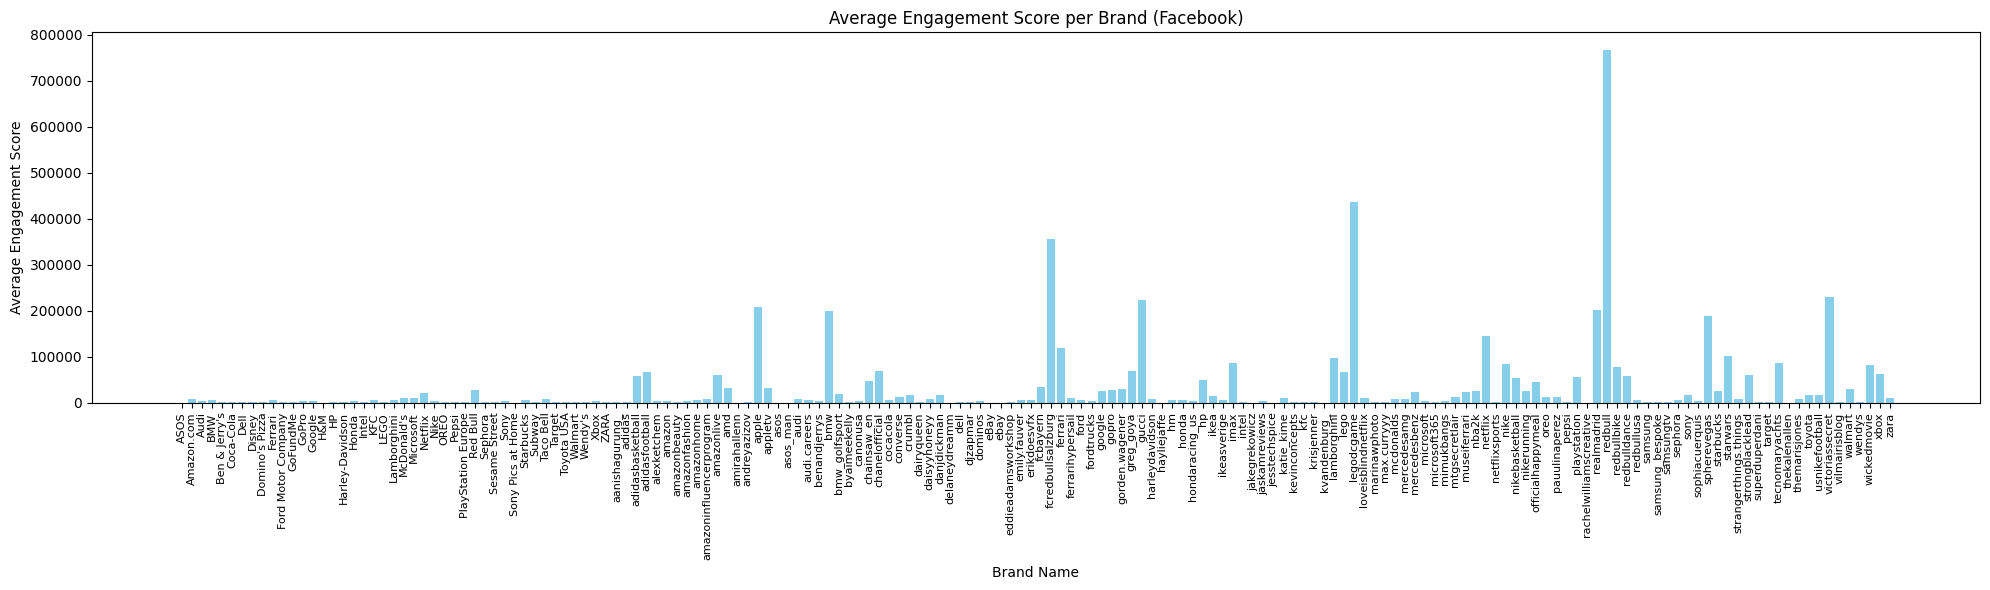

In [15]:
brand_engagement = df.groupby('account_name')['engagement_score'].mean().reset_index()

# Plot
plt.figure(figsize=(20,6))  # wider figure for more labels
plt.bar(brand_engagement['account_name'], brand_engagement['engagement_score'], color='skyblue')

plt.xlabel('Brand Name')
plt.ylabel('Average Engagement Score')
plt.title('Average Engagement Score per Brand (Facebook)')
plt.xticks(rotation=90, fontsize=8)  # rotate and shrink font
plt.tight_layout()
plt.show()

## top 20 brands

In [ ]:
brand_engagement = df.groupby('account_name')['engagement_score'].mean().reset_index()

# sort and select top 20
top20 = brand_engagement.sort_values(by='engagement_score', ascending=False).head(20)

# Plot
plt.figure(figsize=(12,6))
plt.bar(top20['account_name'], top20['engagement_score'], color='skyblue')

plt.xlabel('Brand Name')
plt.ylabel('Average Engagement Score')
plt.title('Top 20 Brands by Average Engagement Score (Facebook)')
plt.xticks(rotation=45, fontsize=9)
plt.tight_layout()
plt.show()


## dealing with  outliers

### 1. engagement score

In [17]:
lower_power=df['engagement_score'].quantile(0.25)
uper_power=df['engagement_score'].quantile(0.75)
iqr=uper_power-lower_power

In [18]:
upper_limit=uper_power+1.5*iqr
lower_limit=lower_power-1.5*iqr

**now we will chk is iqr triming or iqr capping working good on outlyers **

In [19]:
#using iqr triming
df_trimmed = df[
    (df['engagement_score'] > lower_limit) &
    (df['engagement_score'] < upper_limit)
]

/tmp/ipython-input-2173630704.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['engagement_score'])
/tmp/ipython-input-2173630704.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_trimmed['engagement_score'])


<Axes: ylabel='engagement_score'>

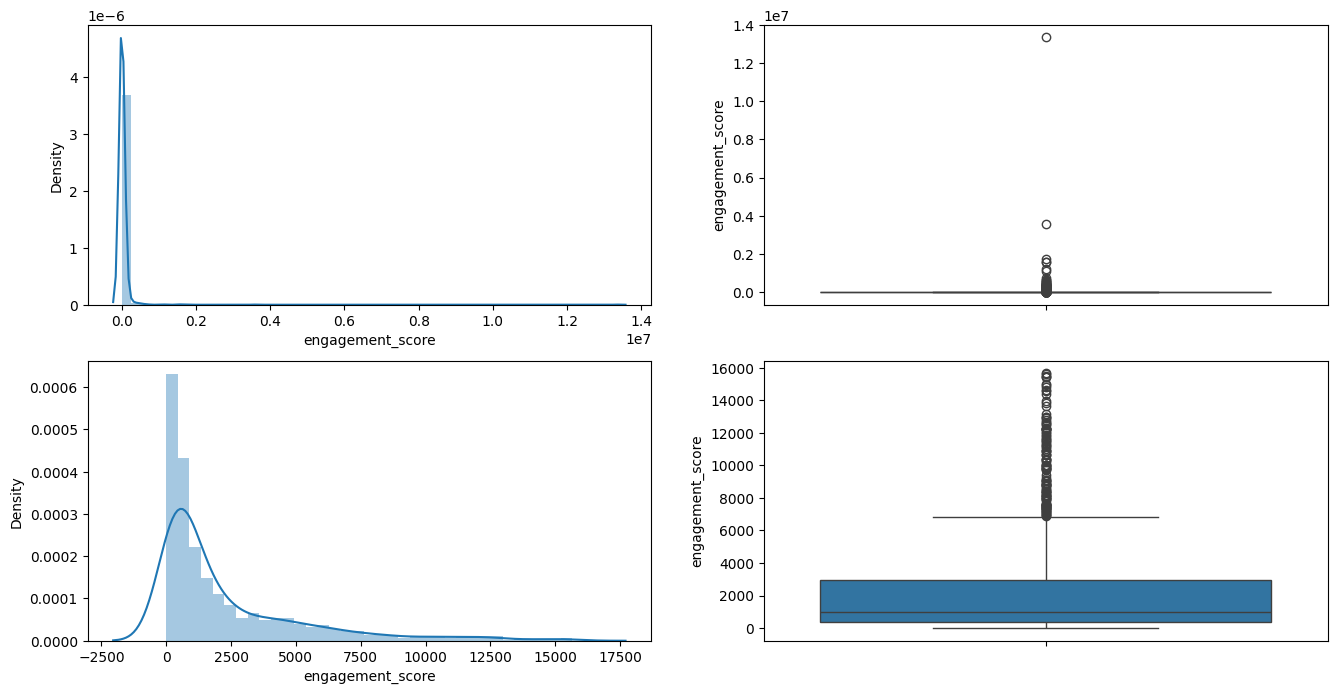

In [20]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df['engagement_score'])

plt.subplot(2,2,2)
sns.boxplot(df['engagement_score'])

plt.subplot(2,2,3)
sns.distplot(df_trimmed['engagement_score'])

plt.subplot(2,2,4)
sns.boxplot(df_trimmed['engagement_score'])

In [21]:
#using iqr capping method
new_df_cap=df.copy()
new_df_cap['engagement_score']=np.where(
    new_df_cap['engagement_score']>upper_limit,
    upper_limit,
    np.where(
        new_df_cap['engagement_score']<lower_limit,
        lower_limit,
        new_df_cap['engagement_score']
    )

)


## visualization 

In [ ]:
brand_engagement = new_df_cap.groupby('account_name')['engagement_score'].mean().reset_index()

# Plot
plt.figure(figsize=(20,6))  # wider figure for more labels
plt.bar(brand_engagement['account_name'], brand_engagement['engagement_score'], color='skyblue')

plt.xlabel('Brand Name')
plt.ylabel('Average Engagement Score')
plt.title('Average Engagement Score per Brand (Facebook)')
plt.xticks(rotation=90, fontsize=8)  # rotate and shrink font
plt.tight_layout()
plt.show()

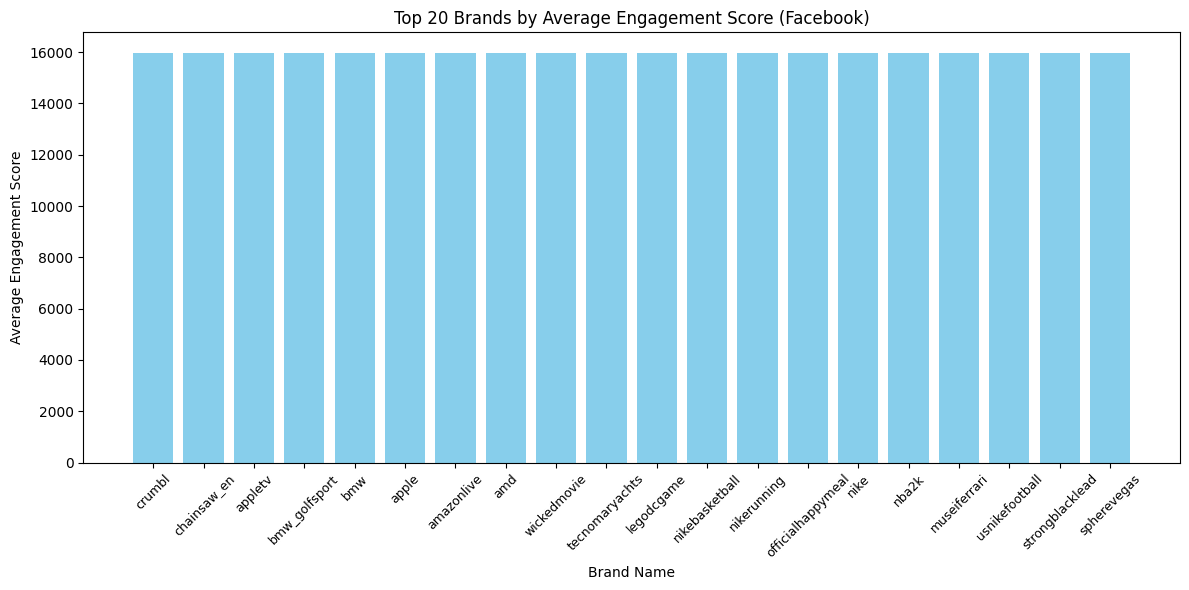

In [23]:
brand_engagement = new_df_cap.groupby('account_name')['engagement_score'].mean().reset_index()

# sort and select top 20
top20 = brand_engagement.sort_values(by='engagement_score', ascending=False).head(20)

# Plot
plt.figure(figsize=(12,6))
plt.bar(top20['account_name'], top20['engagement_score'], color='skyblue')

plt.xlabel('Brand Name')
plt.ylabel('Average Engagement Score')
plt.title('Top 20 Brands by Average Engagement Score (Facebook)')
plt.xticks(rotation=45, fontsize=9)
plt.tight_layout()
plt.show()


/tmp/ipython-input-196828629.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['engagement_score'])
/tmp/ipython-input-196828629.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df_cap['engagement_score'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7c9eb80b2960>,
 'caps': [<matplotlib.lines.Line2D at 0x7c9eb80b2f90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c9eb80b21b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7c9eb80b3530>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c9eb80b37a0>],
 'means': []}

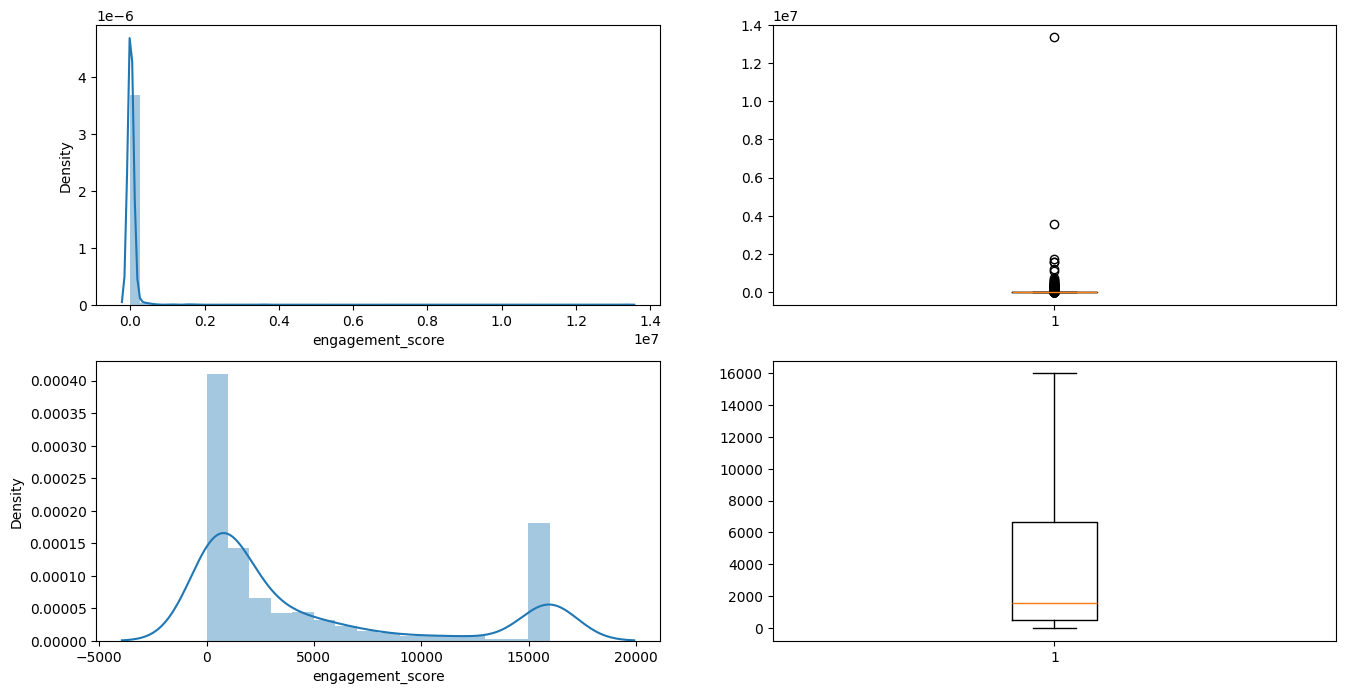

In [24]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df['engagement_score'])
plt.subplot(2,2,2)
plt.boxplot(df['engagement_score'])
plt.subplot(2,2,3)
sns.distplot(new_df_cap['engagement_score'])
plt.subplot(2,2,4)
plt.boxplot(new_df_cap['engagement_score'])

In [25]:
new_df_cap.describe()

,comment_count,like_count,caption_length,word_count,sentiment_score,engagement_score
count,1796.000000,1.796000e+03,1796.000000,1796.000000,1796.000000,1796.000000
mean,436.498330,3.005136e+04,190.222717,29.738307,0.158443,4702.605721
std,1716.816974,3.373496e+05,256.609823,41.033236,0.250448,5879.238862
min,0.000000,2.000000e+00,9.000000,1.000000,-1.000000,2.000000
25%,35.000000,3.927500e+02,69.000000,11.000000,0.000000,488.250000
50%,101.000000,1.312000e+03,128.000000,20.000000,0.100000,1558.500000
75%,307.000000,6.403250e+03,219.250000,34.000000,0.293797,6683.000000
max,46151.000000,1.329798e+07,4001.000000,658.000000,1.000000,15975.125000


In [26]:
new_df_cap.dtypes

,0
account_name,object
caption,object
comment_count,int64
like_count,int64
platform,object
caption_length,int64
word_count,int64
sentiment_score,float64
engagement_score,float64


In [27]:
df.isnull().sum()

,0
account_name,0
caption,0
comment_count,0
like_count,0
platform,0
caption_length,0
word_count,0
sentiment_score,0
engagement_score,0


 **we will use iqr capping method because it handling outlyers better then trimming**
 now we will use it for like and comment also

In [28]:
lower_power=new_df_cap['like_count'].quantile(0.25)
uper_power=new_df_cap['like_count'].quantile(0.75)
iqr=uper_power-lower_power


In [29]:
upper_limit=uper_power+1.5*iqr
lower_limit=lower_power-1.5*iqr

In [30]:
#using iqr capping method
newDf=new_df_cap.copy()
newDf['like_count']=np.where(
    newDf['like_count']>upper_limit,
    upper_limit,
    np.where(
        newDf['like_count']<lower_limit,
        lower_limit,
        newDf['like_count']
    )

)


{'whiskers': [<matplotlib.lines.Line2D at 0x7c9eb7f97740>,
 'caps': [<matplotlib.lines.Line2D at 0x7c9ec2eb5e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c9eb7f97530>],
 'medians': [<matplotlib.lines.Line2D at 0x7c9ec33739e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c9ec3373260>],
 'means': []}

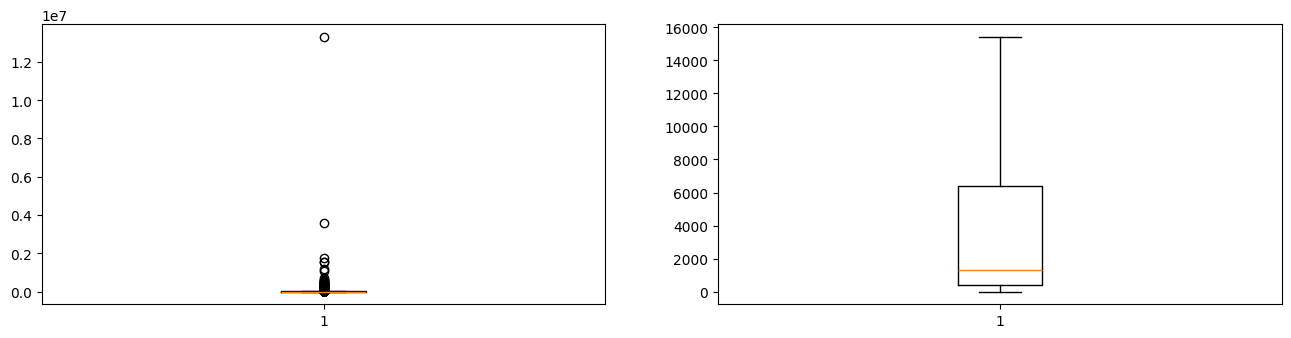

In [31]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.boxplot(df['like_count'])
plt.subplot(2,2,2)
plt.boxplot(newDf['like_count'])

In [32]:
lower_power=newDf['comment_count'].quantile(0.25)
uper_power=newDf['comment_count'].quantile(0.75)
iqr=uper_power-lower_power

In [33]:
upper_limit=uper_power+1.5*iqr
lower_limit=lower_power-1.5*iqr

In [34]:
#using iqr capping method
Df=newDf.copy()
Df['comment_count']=np.where(
    Df['comment_count']>upper_limit,
    upper_limit,
    np.where(
     Df['comment_count']<lower_limit,
        lower_limit,
        Df['comment_count']
    )

)

{'whiskers': [<matplotlib.lines.Line2D at 0x7c9ec3bd2c00>,
 'caps': [<matplotlib.lines.Line2D at 0x7c9ec3bd2990>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c9ec3bd33b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7c9ebabe5cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c9eba9576e0>],
 'means': []}

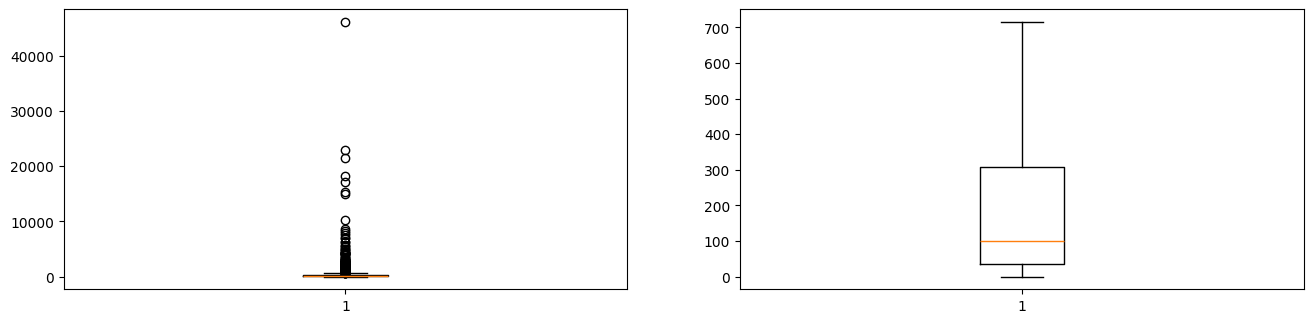

In [35]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.boxplot(df['comment_count'])
plt.subplot(2,2,2)
plt.boxplot(Df['comment_count'])

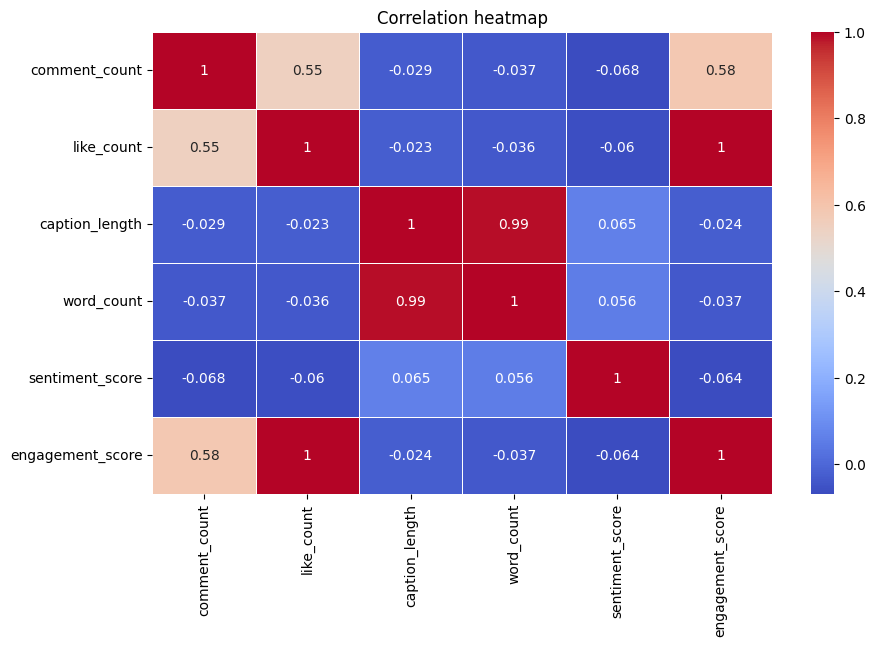

In [36]:
num_df = Df.select_dtypes(include = ["int64", "float64"])
plt.figure(figsize =(10,6))
sns.heatmap(num_df.corr(), annot = True, cmap= "coolwarm", linewidth = 0.5)
plt.title("Correlation heatmap")
plt.show()

using train test split

In [37]:
X=Df.drop(['engagement_score'],axis=1)
Y=Df['engagement_score']

In [38]:
X_train, X_test, Y_train, Y_test= train_test_split(X,Y, test_size=0.2, random_state=42)
X_train

,account_name,caption,comment_count,like_count,platform,caption_length,word_count,sentiment_score
1733,honda,iconic honda prelude making return visit link ...,715.0,15419.0,Instagram,82,16,0.500000
1556,xbox,take favorite games wherever rog xbox ally rog...,715.0,15419.0,Instagram,111,21,0.500000
1641,gopro,rescuing baby shark goproawards recipient vinc...,112.0,15419.0,Instagram,315,49,0.250000
175,Wendy's,little allways went wendys school nd streeet s...,715.0,2521.0,Facebook,172,36,-0.138393
1102,target,laurenwolfe takes us behind scenes woolrich ta...,4.0,460.0,Instagram,189,29,-0.142857
...,...,...,...,...,...,...,...,...
1130,walmart,heard deals coming oct right hearing right,40.0,372.0,Instagram,74,13,0.285714
1294,starbucks,favorite drink add protein,238.0,4297.0,Instagram,37,6,0.500000
860,Amazon.com,eyes sameday delivery amazondelivery skeletons...,715.0,12985.0,Facebook,76,9,0.000000
1459,apple,lets dance commissioned apple new iphone pro b...,488.0,15419.0,Instagram,196,29,0.136364


In [39]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


**now we are going to use columntransformer to handle all columns. under the ColumnTransformer we will use vectorization and one hotencoder for our non numeric columns**

In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        # 1️⃣ Apply TF-IDF on caption
        ('tfidf', TfidfVectorizer(stop_words='english'), 'caption'),

        # 2️⃣ One-Hot Encode account_name & platform
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'),
         ['account_name', 'platform']),

        # 3️⃣ Pass numeric columns as they are
        ('num', 'passthrough',
         ['comment_count', 'like_count', 'caption_length', 'word_count', 'sentiment_score'])
    ]
)

In [41]:
model = Pipeline(steps=[
    ('preprocess', preprocessor),   # your ColumnTransformer
    ('rf', RandomForestRegressor(random_state=42))
])

In [42]:
model.fit(X_train, Y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'caption'),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['account_name', 'platform']),
                                                 ('num', 'passthrough',
                                                  ['comment_count',
                                                   'like_count',
                                                   'caption_length',
                                                   'word_count',
                                                   'sentiment_score'])])),
                ('rf', RandomForestRegressor(random_state=42))])

In [43]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [44]:
y_pred

array([1.59751250e+04, 2.26350000e+02, 1.59751250e+04, 5.63800000e+02,
       6.19005000e+03, 1.35159000e+03, 5.22733000e+03, 2.83705000e+03,
       4.25330000e+02, 1.59713438e+04, 9.58400000e+01, 6.70763000e+03,
       5.22717000e+03, 1.59751250e+04, 3.29708000e+03, 9.56500000e+01,
       1.27800000e+02, 1.83756000e+03, 3.54100000e+01, 9.45950000e+02,
       6.26080000e+02, 1.59751250e+04, 8.81230000e+02, 1.85252000e+03,
       1.59551100e+04, 1.50653000e+03, 8.83160000e+02, 1.74330000e+02,
       5.08794000e+03, 2.44637000e+03, 1.59751250e+04, 2.80170000e+02,
       2.14688000e+03, 1.45287000e+03, 1.68532000e+03, 8.53510000e+02,
       5.82870000e+02, 1.59751250e+04, 2.36052000e+03, 6.86900000e+02,
       1.59751250e+04, 7.86510000e+02, 3.57455000e+03, 4.20716000e+03,
       6.44969000e+03, 5.72407000e+03, 4.45890000e+02, 8.59230000e+02,
       1.49960000e+02, 1.00065800e+04, 6.48450000e+02, 9.97427000e+03,
       4.82670000e+02, 3.86616000e+03, 4.66910000e+02, 1.39895000e+03,
      

In [46]:
print("MSE:", mean_squared_error(Y_test, y_pred))
print("R2 Score:", r2_score(Y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(Y_test, y_pred)))
print("MAE:", mean_absolute_error(Y_test, y_pred))


MSE: 42986.902523328994
R2 Score: 0.9985938005754236
RMSE: 207.3328303075251
MAE: 60.00702430555555
